# [Part 0] Sigmoid, Softmax 구현  

In [1]:
import numpy as np

## [Q1] 함수 구현  

In [ ]:
# sigmoid 
'''
조건
입력값(x): float, int, numpy array 등 (하나 혹은 여러 개의 z값)
출력값(y): x와 동일
'''

def sigmoid(x):
    y=1/(1+np.exp(-x))
    return y

In [ ]:
# softmax
'''
조건
입력값(x_arr): numpy array, list 등 (여러 개의 z값)
출력값(y_arr): x와 동일
'''

def softmax(x_arr):
    expo = np.exp(x_arr)
    expo_sum = np.sum(expo)
    
    y_arr=expo/expo_sum
    return y_arr

## [Q2] 확률 계산  

In [ ]:
# 위에서 정의한 함수를 사용하여 확률을 계산해보세요 
x_arr = np.array([-6.5, 1.03, 5.16, -2.73, 3.34, 0.33, -0.63])

print(f'prob = {sigmoid(x_arr)}')
print(f'prob = {softmax(x_arr)}')

prob = [0.00150118 0.7369159  0.99429108 0.06122616 0.96577584 0.58175938
 0.34751054]
prob = [7.25685867e-06 1.35202933e-02 8.40663757e-01 3.14803000e-04
 1.36209176e-01 6.71397897e-03 2.57073478e-03]


In [ ]:
# softmax 함수의 반환값의 합은?
print(f'sum = {sum(softmax(x_arr))}')

sum = 1.0


# [Part 1] 이진분류 - Personal Loan

In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
myfile = files.upload()

Saving Personal Loan.csv to Personal Loan.csv


In [4]:
# 데이터 불러오기
import pandas as pd
loan=pd.read_csv('Personal Loan.csv').drop(['ID','ZIP Code'],axis=1)
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 2500 non-null   int64  
 1   Experience          2500 non-null   int64  
 2   Income              2500 non-null   int64  
 3   Family              2500 non-null   int64  
 4   CCAvg               2500 non-null   float64
 5   Education           2500 non-null   int64  
 6   Mortgage            2500 non-null   int64  
 7   Personal Loan       2500 non-null   int64  
 8   Securities Account  2500 non-null   int64  
 9   CD Account          2500 non-null   int64  
 10  Online              2500 non-null   int64  
 11  CreditCard          2500 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 234.5 KB


0) 나이  
1) 경력  
2) 수입  
3) 가족단위  
4) 월 카드사용량  
5) 교육수준 (1:Undergrad/2:Graduate/3:Advance)  
6) 가계대출  
7) 개인대출 유무  
8) 유가증권계좌 유무  
9) 양도예금증서 계좌 유무  
10) 온라인계좌 유무  
11) 신용카드 유무   

## [Q1] 데이터 전처리  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0feed92290>,
      dtype=object)

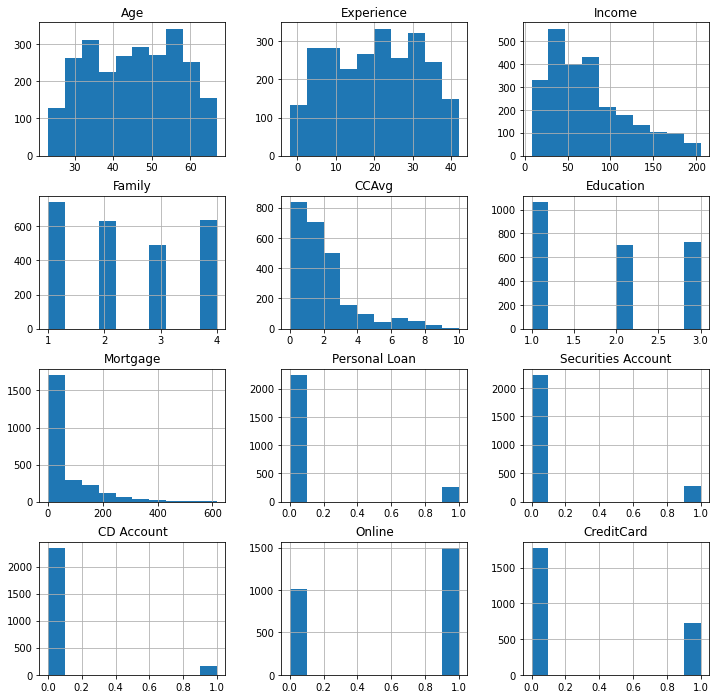

In [ ]:
# [Q1-1] loan의 각 변수별 분포를 확인해주세요 
loan.hist(figsize=(12,12))

In [11]:
# [Q1-2] 연속형 변수(Age,Experience,Income,CCAvg)의 Outlier를 제거하여 loan2에 저장해주세요 

# outlier의 위치 반환 함수
def outliers(data): 
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    IQR=q3-q1
    LB=q1-1.5*IQR #Lower Bound
    UB=q3+1.5*IQR #Upper Bound 

    return np.where((data<LB)|(data>UB))[0]

continuous=['Age','Experience','Income','CCAvg']
loan2=loan

for x in continuous:
    loan2=loan2.drop(outliers(loan2[x]),axis=0)
    loan2=loan2.reset_index(drop=True)

loan2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 2297 non-null   int64  
 1   Experience          2297 non-null   int64  
 2   Income              2297 non-null   int64  
 3   Family              2297 non-null   int64  
 4   CCAvg               2297 non-null   float64
 5   Education           2297 non-null   int64  
 6   Mortgage            2297 non-null   int64  
 7   Personal Loan       2297 non-null   int64  
 8   Securities Account  2297 non-null   int64  
 9   CD Account          2297 non-null   int64  
 10  Online              2297 non-null   int64  
 11  CreditCard          2297 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 215.5 KB


_참고) 모든 이상치가 useless한 것은 아닙니다_  
제거된 이상치의 y분포에 큰 차이가 있는 경우, 이상치 제거시 주의가 필요합니다.  

## [Q2] 훈련세트/테스트 세트 나누기  
+ train : test = 7 : 3 
+ random_state=42
+ y 분포 고려할 것(중요!) 

In [ ]:
y=loan2['Personal Loan']
X=loan2.drop('Personal Loan',axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

## [Q3] 모델 구축 및 훈련
+ StandardScaler()->LogisticRegression()으로 이어지는 파이프라인 구축  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 모델 구축
logr=make_pipeline(StandardScaler(),LogisticRegression())
# 피팅
logr.fit(X_train,y_train)
# 점수
print(f'훈련세트 : {logr.score(X_train,y_train)}')
print(f'테스트세트:{logr.score(X_test,y_test)}')

훈련세트 : 0.9546019900497512
테스트세트:0.9536231884057971


### [Q3-1] 분류 결과 확인  
+ `z_vals` : X_train의 z계산값  
+ `probs` : X_train이 분류될 확률  
+ `pred` : X_train의 분류 예측값 

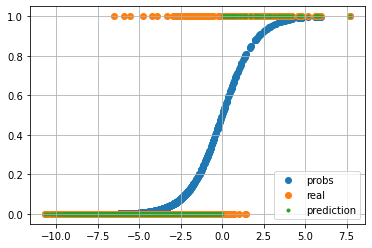

In [ ]:
z_vals=logr.decision_function(X_train)
probs=logr.predict_proba(X_train)
pred=logr.predict(X_train)

plt.scatter(z_vals,probs[:,1])
plt.scatter(z_vals,y_train)
plt.scatter(z_vals,pred,marker='.')
plt.legend(['probs','real','prediction'])
plt.grid()
plt.show()

## [Q4] 모델 평가하기  


In [ ]:
# X_test 분류 결과 
y_pred=logr.predict(X_test)

### [Q4-1] 오차행렬 출력하기
### [Q4-2] ROC 커브 그리기 
### [Q4-3] 정밀도,재현율,f1_score,auc_score 출력함수  

In [ ]:
# [Q4-1]
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix

print(cf_mat(y_test,y_pred))

[[615  10]
 [ 22  43]]


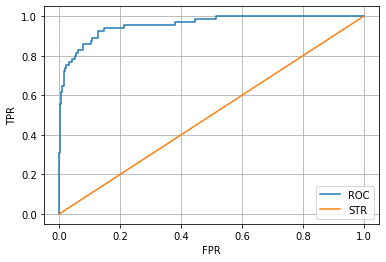

In [ ]:
# [Q4-2]
from sklearn.metrics import roc_curve

    # test세트에서 양성클래스로 분류될 확률
probs_positive=logr.predict_proba(X_test)[:,1]

fprs,tprs,thresholds=roc_curve(y_test,probs_positive)

plt.plot(fprs,tprs,label='ROC')
plt.plot([0,1],[0,1],label='STR')
plt.xlabel('FPR') # 위양성률
plt.ylabel('TPR') # 진양성률
plt.legend()
plt.grid()
plt.show()

In [ ]:
## [Q4-3] 
def print_evaluation(y_test,y_pred):
    from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score

    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test, y_pred)


    print(f'정밀도 : {precision}')
    print(f'재현율 : {recall}')
    print(f'f1_score : {f1}')
    print(f'AUC Score : {auc}')

print_evaluation(y_test,y_pred)

정밀도 : 0.8113207547169812
재현율 : 0.6615384615384615
f1_score : 0.7288135593220341
AUC Score : 0.8227692307692307


### [Q4-4] classify with threshold  
threshold(평가 기준)을 사용자가 임의로 설정하여 분류하는 함수  

In [ ]:
# classify_with_threshold
'''
조건
p: 데이터가 양성 클래스에 속할 확률 (array)
threshold: 평가 기준. 0과 1 사이. 기본값은 0.5. (float)
p2: p가 손상되는 경우를 막기 위해 복사하여 사용. 출력값 p2는 0 혹은 1로 분류한 결과값 (array)
'''

def classify_with_threshold(p, threshold=0.5):
  p2 = p.copy()
  p2[p2>threshold] = 1
  p2[p2<threshold] = 0
  
  return p2

In [ ]:
thresholds = np.arange(0, 1, 0.1)       #thresholds를 0, 0.1, 0.2, ... 1까지 변화할 수 있도록 array를 만든다
probs = logr.predict_proba(X_test)
probs_positive = probs[:, 1]              #target값인 1일 확률. 즉, 양성 클래스일 확률.

for threshold in thresholds:
  y_pred = classify_with_threshold(probs_positive, threshold)
  print(f'--- threshold가 {threshold}일 때 ---')
  print_evaluation(y_test, y_pred)
  print()

--- threshold가 0.0일 때 ---
정밀도 : 0.09420289855072464
재현율 : 1.0
f1_score : 0.17218543046357618
AUC Score : 0.5

--- threshold가 0.1일 때 ---
정밀도 : 0.4264705882352941
재현율 : 0.8923076923076924
f1_score : 0.5771144278606964
AUC Score : 0.8837538461538461

--- threshold가 0.2일 때 ---
정밀도 : 0.5684210526315789
재현율 : 0.8307692307692308
f1_score : 0.675
AUC Score : 0.8825846153846155

--- threshold가 0.30000000000000004일 때 ---
정밀도 : 0.7101449275362319
재현율 : 0.7538461538461538
f1_score : 0.7313432835820897
AUC Score : 0.8609230769230769

--- threshold가 0.4일 때 ---
정밀도 : 0.8
재현율 : 0.7384615384615385
f1_score : 0.768
AUC Score : 0.8596307692307692

--- threshold가 0.5일 때 ---
정밀도 : 0.8113207547169812
재현율 : 0.6615384615384615
f1_score : 0.7288135593220341
AUC Score : 0.8227692307692307

--- threshold가 0.6000000000000001일 때 ---
정밀도 : 0.8888888888888888
재현율 : 0.6153846153846154
f1_score : 0.7272727272727274
AUC Score : 0.8036923076923077

--- threshold가 0.7000000000000001일 때 ---
정밀도 : 0.9230769230769231
재현율 : 

<br/>  

---  
# [Part 2] 다중분류 - MNIST

데이터를 준비하겠습니다.  


In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False)

X=mnist.data
y=mnist.target
print(X.shape,y.shape)

(70000, 784) (70000,)


<br/>  
임의의 데이터를 확인해 봅시다. 

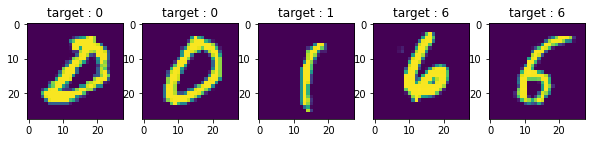

In [ ]:
# 임의의 5개 샘플 확인하기
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
random_index=np.random.randint(0,70000,size=5)

X_list = []
for i in range(5):
    tmp = X[random_index[i]]
    tmp = tmp.reshape(28, 28)
    X_list.append(tmp)


plt.figure(figsize=(10,50))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_list[i])
    plt.title(f'target : {y[random_index[i]]}')

## [Q1] 훈련세트/테스트 세트 나누기  

+ train : test = 8 : 2
+ random_state=42  

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(56000, 784) (56000,) (14000, 784) (14000,)


## [Q2] 모델 구축 및 훈련  
+ max_iter=1000  
+ 훈련은 처음 1500개의 데이터로 `X_train[:1500]`  
+ 테스트는 처음 300개의 데이터로 `X_test[:300]`

In [ ]:
from sklearn.linear_model import LogisticRegression
# 모델 구축
logr=LogisticRegression(max_iter=1000)
# 모델 피팅
logr.fit(X_train[:1500],y_train[:1500])
# 점수 저장
train_score=logr.score(X_train[:1500],y_train[:1500])
test_score=logr.score(X_test[:300],y_test[:300])

print(f'훈련데이터 점수 : {train_score}')
print(f'테스트데이터 점수: {test_score}')

훈련데이터 점수 : 1.0
테스트데이터 점수: 0.8666666666666667


## [Q3] 모델 평가하기  
+ 오차행렬을 출력해주세요  

In [ ]:
from sklearn.metrics import confusion_matrix
cf_max=confusion_matrix

y_pred=logr.predict(X_test[:300])
cf_max(y_test[:300],y_pred)

array([[22,  0,  0,  0,  0,  1,  1,  0,  1,  0],
       [ 0, 36,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 16,  0,  0,  1,  1,  0,  1,  0],
       [ 0,  0,  2, 32,  0,  2,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 23,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0, 25,  1,  1,  2,  0],
       [ 0,  0,  3,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 31,  0,  1],
       [ 0,  0,  1,  1,  0,  5,  0,  1, 22,  0],
       [ 0,  1,  0,  1,  2,  0,  0,  1,  2, 27]])

2번 row를 주목해주세요  
True `'2'` =16  
False `'not 2'` =4 입니다. 

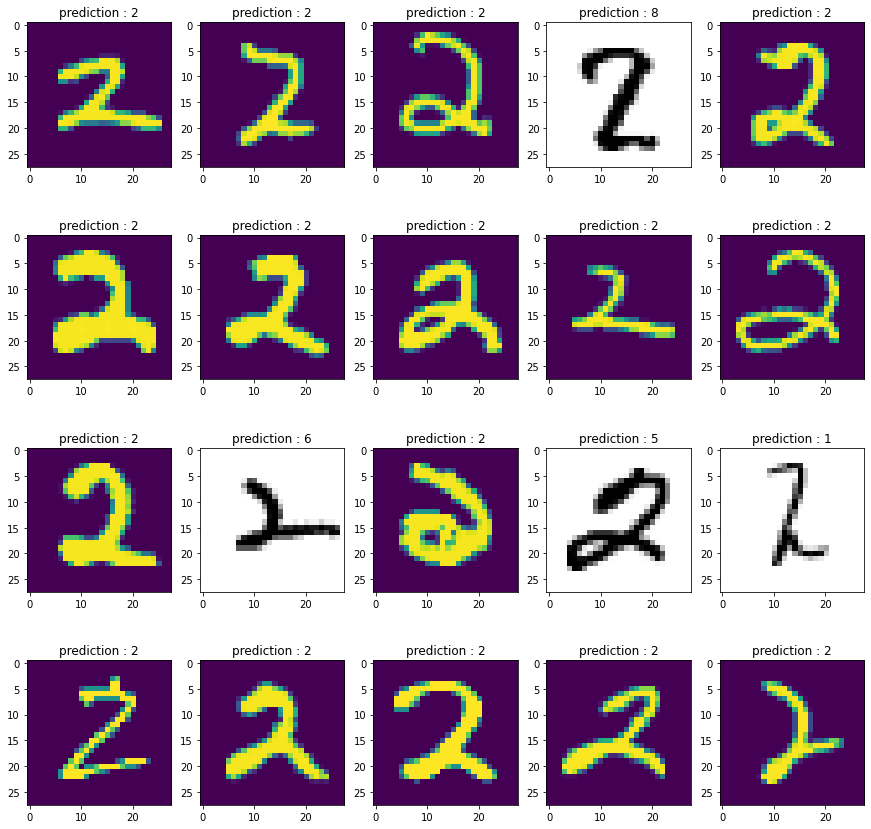

In [ ]:
# 이미지로 구분해 봅시다
num2_index=np.where(y_test[:300]=='2')[0]

plt.figure(figsize=(15,15))
for i,j in enumerate(num2_index):
    tmp=X_test[j].reshape(28,28)
    plt.subplot(4,5,i+1)
    if y_pred[j]!='2': 
        # False not 2 (다른 숫자로 잘못 예측)
        plt.imshow(tmp,cmap=plt.cm.binary)
    else: 
        # True 2 (잘 예측)
        plt.imshow(tmp)
    plt.title(f'prediction : {y_pred[j]}')

### [Q4] True `'0'`와 False `'not0'` 를 구분하는 plot을 그려보세요  

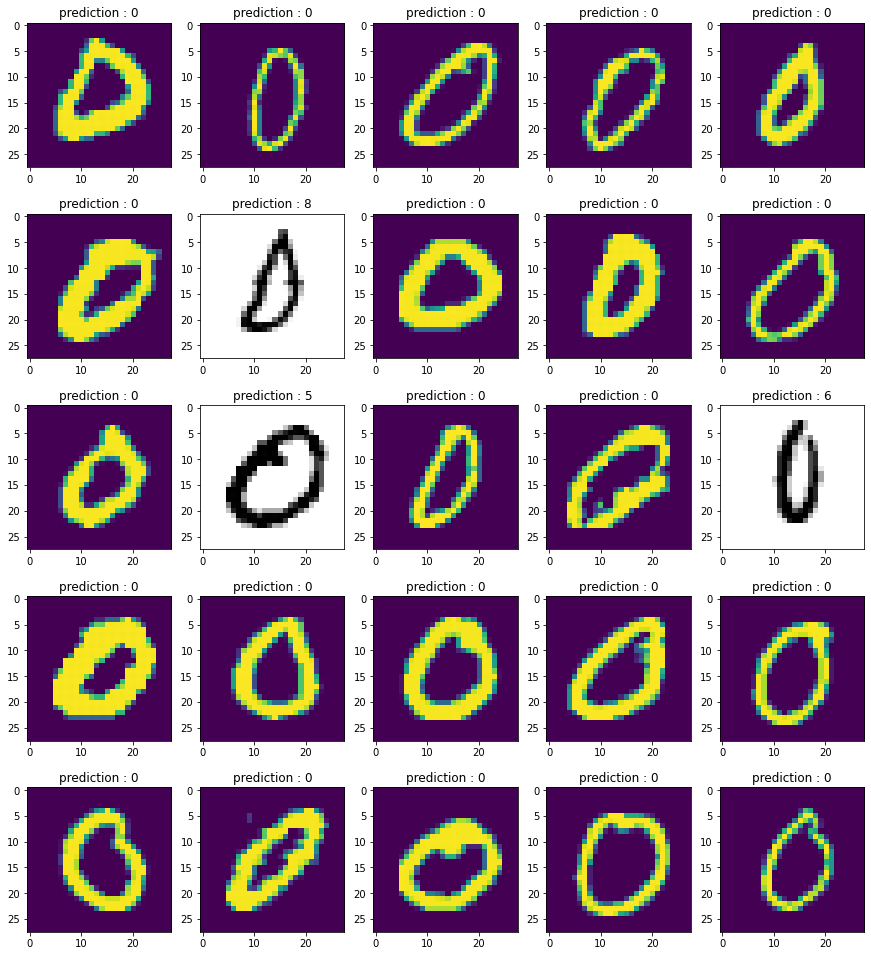

In [ ]:
num0_index=np.where(y_test[:300]=='0')[0]

plt.figure(figsize=(15,17))
for i,j in enumerate(num0_index):
    tmp=X_test[j].reshape(28,28)
    plt.subplot(5,5,i+1)
    if y_pred[j]!='0':
        plt.imshow(tmp,cmap=plt.cm.binary)
    else:
        plt.imshow(tmp)
    plt.title(f'prediction : {y_pred[j]}')